# Cassava Leaf Disease Classification
Details: [kaggle.com](https://www.kaggle.com/c/cassava-leaf-disease-classification)

## Prepare kaggle dataset

In [7]:
!pip install -q kaggle
!wget -q https://github.com/MohammadRaziei/Deep-Learning-Course/raw/master/Project/kaggle/key/kaggle.json -O ~/.kaggle/kaggle.json
!sleep 5; chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

ref                                                    title                                                size  lastUpdated          downloadCount  
-----------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
ayushggarg/all-trumps-twitter-insults-20152021         All Trump's Twitter insults (2015-2021)             581KB  2021-01-20 16:51:05           1202  
sevgisarac/temperature-change                          Temperature change                                  778KB  2020-12-24 20:06:36           1255  
jorgesandoval/wind-power-generation                    Wind Power Generation Data                          245KB  2021-01-07 18:45:08            512  
cdminix/us-drought-meteorological-data                 US Drought & Meteorological Data                    748MB  2021-01-20 21:48:02            177  
fedesoriano/cern-electron-collision-data               CERN electron collision data           

In [8]:
!mkdir -p Dataset
!kaggle competitions download -c cassava-leaf-disease-classification --path Dataset

  0% 0.00/150k [00:00<?, ?B/s]
100% 150k/150k [00:00<00:00, 56.5MB/s]
  0% 0.00/135k [00:00<?, ?B/s]
100% 135k/135k [00:00<00:00, 44.9MB/s]
  0% 0.00/119k [00:00<?, ?B/s]
100% 119k/119k [00:00<00:00, 39.1MB/s]
  0% 0.00/101k [00:00<?, ?B/s]
100% 101k/101k [00:00<00:00, 110MB/s]
  0% 0.00/104k [00:00<?, ?B/s]
100% 104k/104k [00:00<00:00, 106MB/s]
  0% 0.00/136k [00:00<?, ?B/s]
100% 136k/136k [00:00<00:00, 45.2MB/s]
  0% 0.00/79.1k [00:00<?, ?B/s]
100% 79.1k/79.1k [00:00<00:00, 69.4MB/s]
  0% 0.00/127k [00:00<?, ?B/s]
100% 127k/127k [00:00<00:00, 133MB/s]
  0% 0.00/170k [00:00<?, ?B/s]
100% 170k/170k [00:00<00:00, 55.9MB/s]
  0% 0.00/100k [00:00<?, ?B/s]
100% 100k/100k [00:00<00:00, 91.1MB/s]
  0% 0.00/82.3k [00:00<?, ?B/s]
100% 82.3k/82.3k [00:00<00:00, 83.8MB/s]
  0% 0.00/110k [00:00<?, ?B/s]
100% 110k/110k [00:00<00:00, 97.4MB/s]
  0% 0.00/101k [00:00<?, ?B/s]
100% 101k/101k [00:00<00:00, 103MB/s]
  0% 0.00/131k [00:00<?, ?B/s]
100% 131k/131k [00:00<00:00, 133MB/s]
  0% 0.00/83.5k [00

In [15]:
import zipfile
import shutil, pathlib
from tqdm.auto import tqdm

def unzip_file(filename, target_path='.'):
  zf = zipfile.ZipFile(filename, 'r')
  zf.extractall(target_path)
  zf.close()

def unzip_files(filename_list, target_path='.'):
  for filename in tqdm(zip_files):
    unzip_file(filename, target_path)

def create_path(path):
  pathlib.Path(path).mkdir(parents=True, exist_ok=True)

def remove_path(path):
  shutil.rmtree(path, ignore_errors=True)

def recreate_path(path):
  remove_path(path)
  create_path(path)

In [16]:
import glob
zip_files = glob.glob('Dataset/*.zip')
unzip_files(zip_files, target_path='Dataset')

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image


def resize_image(image, target_size=(100,100)):
    img = Image.fromarray(image)
    img = img.resize(target_size, Image.ANTIALIAS)
    img = np.asarray(img)
    return img

""" 
I recommend to see following websites:
  * https://stepup.ai/exploring_data_augmentation_keras/
  * https://machinelearningmastery.com/how-to-load-large-datasets-from-directories-for-deep-learning-with-keras/
"""
# create generator
datagen = ImageDataGenerator()
train_it = datagen.flow_from_directory('data/train/', class_mode='binary')
val_it = datagen.flow_from_directory('data/validation/', class_mode='binary')
test_it = datagen.flow_from_directory('data/test/', class_mode='binary')



In [17]:
import os
import pandas as pd

data_path = "Dataset/"
train_csv_data_path  = os.path.join(data_path, "train.csv")
label_json_data_path = os.path.join(data_path, "label_num_to_disease_map.json")
images_dir_data_path = os.path.join(data_path, "train_images")

train_csv = pd.read_csv(train_csv_data_path)
train_csv['label'] = train_csv['label'].astype('string')

label_class = pd.read_json(label_json_data_path, orient='index')
label_class = label_class.values.flatten().tolist()


In [18]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

label_encoder = LabelEncoder()
label_encoder.fit(label_class)
label_encode = lambda arr_str: list(label_encoder.transform(arr_str))
label_decode = lambda arr: list(label_encoder.inverse_transform(arr))
pd.DataFrame(label_encoder.classes_, columns=['Label names'])

,Label names
0,Cassava Bacterial Blight (CBB)
1,Cassava Brown Streak Disease (CBSD)
2,Cassava Green Mottle (CGM)
3,Cassava Mosaic Disease (CMD)
4,Healthy


In [62]:
train_csv

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3
...,...,...
21392,999068805.jpg,3
21393,999329392.jpg,3
21394,999474432.jpg,1
21395,999616605.jpg,4


In [20]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
# GCS_PATH = "gs://kds-b38ce1b823c3ae623f5691483dbaa0f0363f04b0d6a90b63cf69946e"
BATCH_SIZE = 64
IMAGE_SIZE = [512, 512]

In [21]:
from functools import partial

def decode_image(image, image_size):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.reshape(image, image_size)

    return image

def read_tfrecord(example, labeled, image_size):
    tfrecord_format = (
        {
            "image": tf.io.FixedLenFeature([], tf.string),
            "target": tf.io.FixedLenFeature([], tf.int64),
        }
        if labeled
        else {"image": tf.io.FixedLenFeature([], tf.string),}
    )
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example["image"], image_size)
    if labeled:
        label = tf.cast(example["target"], tf.int32)
        return image, label
    return image

def load_dataset(filenames, labeled, image_size):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # disable order, increase speed
    dataset = tf.data.TFRecordDataset(
        filenames
    )  # automatically interleaves reads from multiple files
    dataset = dataset.with_options(
        ignore_order
    )  # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(
        partial(read_tfrecord, labeled=labeled, image_size=image_size), num_parallel_calls=AUTOTUNE
    )
    # returns a dataset of (image, label) pairs if labeled=True or just images if labeled=False
    return dataset

def get_dataset(filenames, labeled=True, batch_size=BATCH_SIZE, image_size=[*IMAGE_SIZE, 3]):
    dataset = load_dataset(filenames, labeled=labeled, image_size=image_size)
    dataset = dataset.shuffle(2048)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    dataset = dataset.batch(batch_size)
    return dataset



In [25]:
sample_dataset = get_dataset(["Dataset/ld_train15-1327.tfrec"])

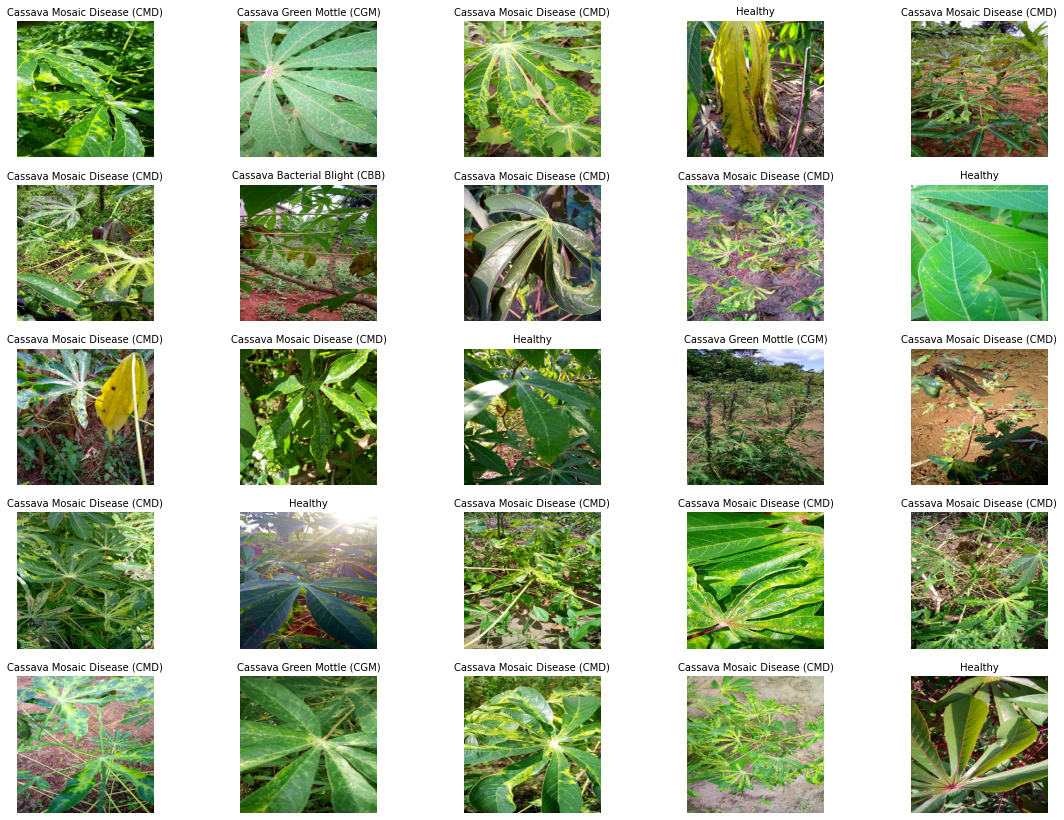

In [88]:
image_batch, label_batch = next(iter(sample_dataset))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(8, 8))
    plt.tight_layout()
    plt.subplots_adjust(right=2., top=1.5)
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n] / 255.0)
        plt.title(*label_decode([label_batch[n]]), fontsize=10)
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

In [22]:
FILENAMES = tf.io.gfile.glob("Dataset/ld_train*.tfrec")
split_ind = int(0.95 * len(FILENAMES))
TRAINING_FILENAMES, VALID_FILENAMES = FILENAMES[:split_ind], FILENAMES[split_ind:]

# TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + "/tfrecords/test*.tfrec")
print("Train TFRecord Files:", len(TRAINING_FILENAMES))
print("Validation TFRecord Files:", len(VALID_FILENAMES))
# print("Test TFRecord Files:", len(TEST_FILENAMES))

train_dataset = get_dataset(TRAINING_FILENAMES)
valid_dataset = get_dataset(VALID_FILENAMES)
# test_dataset = get_dataset(TEST_FILENAMES, labeled=False)

Train TFRecord Files: 15
Validation TFRecord Files: 1


In [24]:
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=20, decay_rate=0.96, staircase=True
)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "melanoma_model.h5", save_best_only=True
)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True
)

In [25]:
def make_model():
    base_model = tf.keras.applications.Xception(
        input_shape=(*IMAGE_SIZE, 3), include_top=False, weights="imagenet"
    )

    base_model.trainable = False

    inputs = tf.keras.layers.Input([*IMAGE_SIZE, 3])
    x = tf.keras.applications.xception.preprocess_input(inputs)
    x = base_model(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(8, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.7)(x)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss="binary_crossentropy",
        metrics=tf.keras.metrics.AUC(name="auc"),
    )

    return model

In [ ]:
model = make_model()

history = model.fit(
    train_dataset,
    epochs=1,
    validation_data=valid_dataset,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

83689472/83683744 [==============================] - 1s 0us/step
    296/Unknown - 427s 1s/step - loss: -1984.2968 - auc: 0.5031

In [5]:
data=tf.data.TFRecordDataset(filenames = ['Dataset/ld_train00-1338.tfrec'])

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3
...,...,...
21392,999068805.jpg,3
21393,999329392.jpg,3
21394,999474432.jpg,1
21395,999616605.jpg,4


Label names :
 0. Cassava Bacterial Blight (CBB)
 1. Cassava Brown Streak Disease (CBSD)
 2. Cassava Green Mottle (CGM)
 3. Cassava Mosaic Disease (CMD)
 4. Healthy


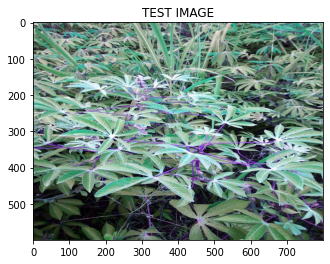

In [95]:
import matplotlib.pyplot as plt
import cv2
BATCH_SIZE = 18
IMG_SIZE = 224

test_img_path = os.path.join(data_path,"2216849948.jpg")

img = cv2.imread(test_img_path)
resized_img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)).reshape(-1, IMG_SIZE, IMG_SIZE, 3)/255

plt.figure(figsize=(8,4))
plt.title("TEST IMAGE")
plt.imshow(resized_img[0])
plt.show()

In [ ]:
preds = []
ss = pd.read_csv(data_path+'sample_submission.csv')

for image in ss.image_id:
    img = tf.keras.preprocessing.image.load_img(data_path+'test_images/' + image)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.preprocessing.image.smart_resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.reshape(img, (-1, IMG_SIZE, IMG_SIZE, 3))
    prediction = model_model.predict(img/255)
    preds.append(np.argmax(prediction))

my_submission = pd.DataFrame({'image_id': ss.image_id, 'label': preds})
my_submission.to_csv('submission.csv', index=False)

In [10]:
raw_example = next(iter(data))


In [11]:
raw_example

<tf.Tensor: shape=(), dtype=string, numpy=b'\n\x99\xc4\x0b\n\x0f\n\x06target\x12\x05\x1a\x03\n\x01\x00\n \n\nimage_name\x12\x12\n\x10\n\x0e1000015157.jpg\n\xe2\xc3\x0b\n\x05image\x12\xd7\xc3\x0b\n\xd3\xc3\x0b\n\xcf\xc3\x0b\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x01,\x01,\x00\x00\xff\xdb\x00C\x00\x02\x01\x01\x01\x01\x01\x02\x01\x01\x01\x02\x02\x02\x02\x02\x04\x03\x02\x02\x02\x02\x05\x04\x04\x03\x04\x06\x05\x06\x06\x06\x05\x06\x06\x06\x07\t\x08\x06\x07\t\x07\x06\x06\x08\x0b\x08\t\n\n\n\n\n\x06\x08\x0b\x0c\x0b\n\x0c\t\n\n\n\xff\xdb\x00C\x01\x02\x02\x02\x02\x02\x02\x05\x03\x03\x05\n\x07\x06\x07\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\xff\xc0\x00\x11\x08\x02\x00\x02\x00\x03\x01\x11\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1e\x00\x00\x01\x05\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x06\x03\x04\x05\x07\x08\t\x02\x01\x00\n\xff\xc4\x00L\x10\x00\x01\x03\x03\x03\x02\x04\x04\x05\x02\x03\x06\x03\x07\x00\x0b\x01\x02\x03\x04\